In [130]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
import bento as bt

%matplotlib inline

# Load combined density data for basic comparative analysis

In [131]:
adata = sc.read("/mnt/d/ebola/data/48hpt_combined_density.h5ad")
adata

AnnData object with n_obs × n_vars = 31606 × 134
    obs: 'cell', 'cell_area', 'cell_count', 'compartment'

In [132]:
adata.layers["density"] = adata.X.copy()

## Goal: show difference in density between compartments more clearly
> plot normalized density (compartment specific density normalized to cell density) and compare Cytoplasm vs Condensate side by side. So the value and mean difference are not too small to appreciate

In [133]:
density_long = (
    adata.to_df()
    .groupby(adata.obs["compartment"])
    .apply(lambda x: x.mean(axis=1, skipna=True))
    .reset_index()
    .melt(id_vars="compartment")
)
density_long = density_long.rename(columns={"variable": "cell", "value": "density"})

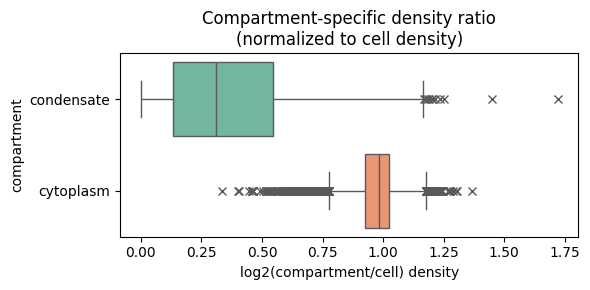

In [134]:
plt.figure(figsize=(6, 3))
sns.boxplot(
    data=density_long,
    y="compartment",
    x="density",
    hue="compartment",
    width=0.8,
    palette="Set2",
    flierprops={"marker": "x"},
)
plt.xlabel("log2(compartment/cell) density")
plt.title("Compartment-specific density ratio\n(normalized to cell density)")
plt.tight_layout()


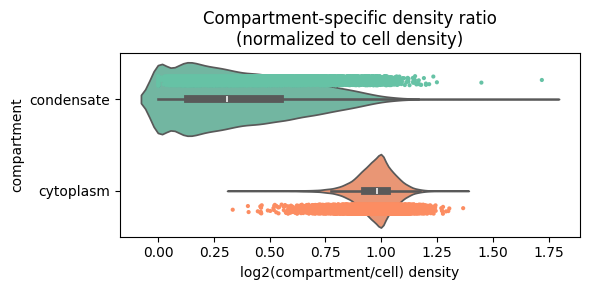

In [135]:
plt.figure(figsize=(6, 3))
sns.violinplot(
    data=density_long,
    y="compartment",
    x="density",
    hue="compartment",
    width=0.8,
    palette="Set2",
)
sns.stripplot(
    data=density_long,
    y="compartment",
    x="density",
    hue="compartment",
    s=3,
    c="black",
    dodge=True,
    jitter=0.1,
    palette="Set2",
    alpha=1,
)
plt.xlabel("log2(compartment/cell) density")
plt.title("Compartment-specific density ratio\n(normalized to cell density)")
plt.tight_layout()


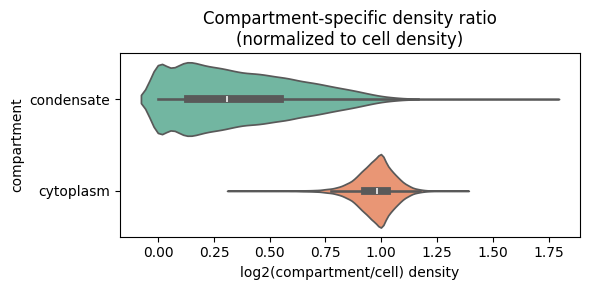

In [136]:
plt.figure(figsize=(6, 3))
sns.violinplot(
    data=density_long,
    y="compartment",
    x="density",
    hue="compartment",
    width=0.8,
    palette="Set2",
)

plt.xlabel("log2(compartment/cell) density")
plt.title("Compartment-specific density ratio\n(normalized to cell density)")
plt.tight_layout()


In [137]:
density_long.groupby("compartment").describe()
# Differential density analysis

density                                                    \
               count      mean       std       min       25%       50%   
compartment                                                              
condensate   15803.0  0.353709  0.267254  0.000000  0.132274  0.310582   
cytoplasm    15803.0  0.972426  0.087714  0.334188  0.925474  0.981090   

                                 
                  75%       max  
compartment                      
condensate   0.545982  1.720086  
cytoplasm    1.025608  1.367318

In [138]:
adata.X = adata.to_df().fillna(0).to_numpy()

# Differential density analysis

Find genes whose density changes between compartments
- use wilcoxon rank-sum test (probably better way to do this)

In [139]:
sc.tl.rank_genes_groups(adata, groupby="compartment", method="t-test")

In [140]:
sc.get.rank_genes_groups_df(adata, "condensate")

,names,scores,logfoldchanges,pvals,pvals_adj
0,Blank-4,-12.815323,-1.405559,1.669641e-37,1.669641e-37
1,AC021092.1,-13.257689,-1.442085,5.210564e-40,5.249741e-40
2,PLAAT4,-13.357184,-1.475244,1.386128e-40,1.407130e-40
3,TMSB4X,-13.457601,-1.915102,3.635498e-41,3.718754e-41
4,Blank-28,-13.563469,-1.551564,8.643298e-42,8.909245e-42
...,...,...,...,...,...
129,STAT1,-73.670380,-1.753853,0.000000e+00,0.000000e+00
130,ZC3HAV1,-76.137650,-1.674415,0.000000e+00,0.000000e+00
131,PFKFB3,-78.554688,-2.015574,0.000000e+00,0.000000e+00
132,MOV10,-84.579170,-2.182565,0.000000e+00,0.000000e+00


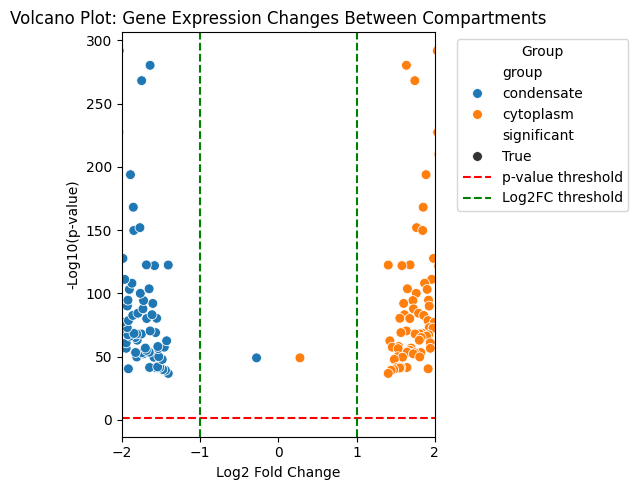

Number of significant genes per group:
group
condensate    134
cytoplasm     134
dtype: int64

Top 5 up-regulated genes in condensate:
       gene    log2fc          pval
10     ODC1 -0.277283  8.133967e-50
103    IARS -1.011955  0.000000e+00
110   BCL7A -1.344544  0.000000e+00
125  NFE2L1 -1.363445  0.000000e+00
115  SHISA5 -1.365888  0.000000e+00

Top 5 down-regulated genes in condensate:
       gene    log2fc           pval
133  MAP3K5 -2.355393   0.000000e+00
72   ANXA2R -2.428241  5.630730e-232
67    ZNF10 -2.456003  2.565304e-171
82     SAT1 -2.476543   0.000000e+00
95   BTN3A3 -2.869218   0.000000e+00

Top 5 up-regulated genes in cytoplasm:
       gene    log2fc           pval
172  BTN3A3  2.869218   0.000000e+00
185    SAT1  2.476543   0.000000e+00
200   ZNF10  2.456003  2.565304e-171
195  ANXA2R  2.428241  5.630730e-232
134  MAP3K5  2.355393   0.000000e+00

Top 5 down-regulated genes in cytoplasm:
       gene    log2fc          pval
152  SHISA5  1.365888  0.000000e+00
142  NFE

In [141]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Extract results from rank_genes_groups
results = adata.uns["rank_genes_groups"]
groups = results["names"].dtype.names

# Create a DataFrame to store the results
volcano_data = pd.DataFrame()

for group in groups:
    temp_df = pd.DataFrame(
        {
            "gene": results["names"][group],
            "log2fc": results["logfoldchanges"][group],
            "pval": results["pvals"][group],
            "group": group,
        }
    )
    volcano_data = pd.concat([volcano_data, temp_df]).reset_index(drop=True)

# Calculate -log10(pvalue)
volcano_data["-log10pval"] = -np.log10(volcano_data["pval"])

# Add a column to color significant genes
volcano_data["significant"] = volcano_data["pval"] < 0.05

# Create the volcano plot
plt.figure(figsize=(6, 5))
plt.xlim(-2, 2)
sns.scatterplot(
    data=volcano_data,
    x="log2fc",
    y="-log10pval",
    hue="group",
    style="significant",
    s=50,
)

plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(p-value)")
plt.title("Volcano Plot: Gene Expression Changes Between Compartments")

# Add a horizontal line for p-value threshold
plt.axhline(y=-np.log10(0.05), color="red", linestyle="--", label="p-value threshold")

# Add vertical lines for log2fc thresholds
plt.axvline(x=1, color="green", linestyle="--", label="Log2FC threshold")
plt.axvline(x=-1, color="green", linestyle="--")

plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left")

# Add labels for some top genes (optional)
top_genes = volcano_data[volcano_data["significant"]].nlargest(10, "-log10pval")
for _, gene in top_genes.iterrows():
    plt.annotate(
        gene["gene"],
        (gene["log2fc"], gene["-log10pval"]),
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.5),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
    )

plt.tight_layout()
plt.show()

# Add a summary of significant genes
significant_counts = volcano_data[volcano_data["significant"]].groupby("group").size()
print("Number of significant genes per group:")
print(significant_counts)

# Display top 5 up-regulated and down-regulated genes for each group
for group in groups:
    group_data = volcano_data[volcano_data["group"] == group].sort_values(
        "log2fc", ascending=False
    )
    print(f"\nTop 5 up-regulated genes in {group}:")
    print(group_data.head()[["gene", "log2fc", "pval"]])
    print(f"\nTop 5 down-regulated genes in {group}:")
    print(group_data.tail()[["gene", "log2fc", "pval"]])


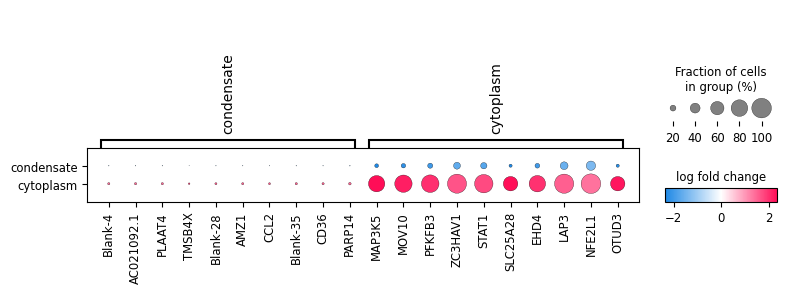

In [142]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="compartment",
    cmap=bt.colors.red2blue,
    values_to_plot="logfoldchanges",
)


In [143]:
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1.0, key_added="leiden_1.0")
sc.tl.leiden(adata, resolution=0.5, key_added="leiden_0.5")
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_0.1")


In [144]:
coef = adata.to_df()
genes_sorted = coef.mean().sort_values(ascending=False).index.tolist()[:50]

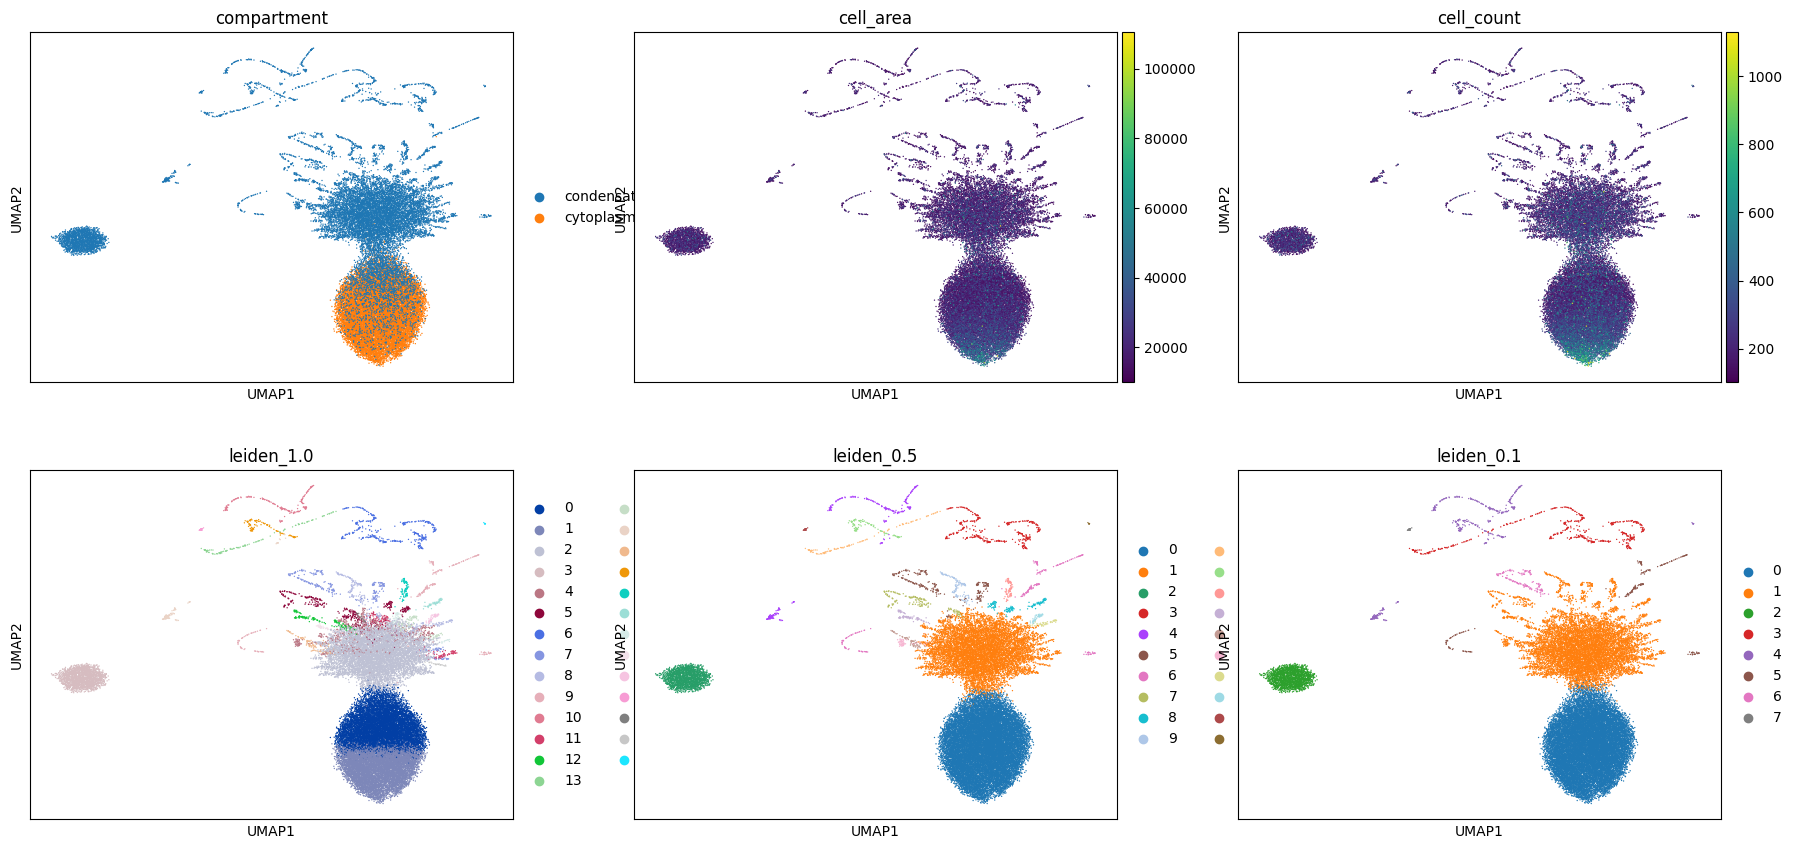

<Figure size 640x480 with 0 Axes>

In [145]:
sc.pl.umap(
    adata,
    color=[
        "compartment",
        "cell_area",
        "cell_count",
        "leiden_1.0",
        "leiden_0.5",
        "leiden_0.1",
    ],
    ncols=3,
)
plt.tight_layout()

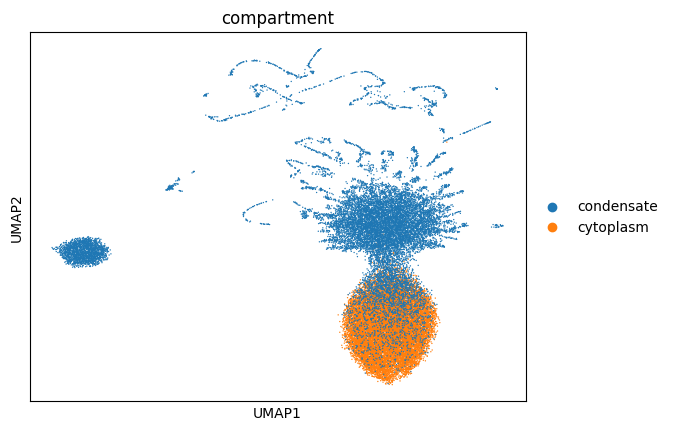

In [146]:
sc.pl.umap(
    adata,
    color=[
        "compartment",
    ],
    ncols=4,
)

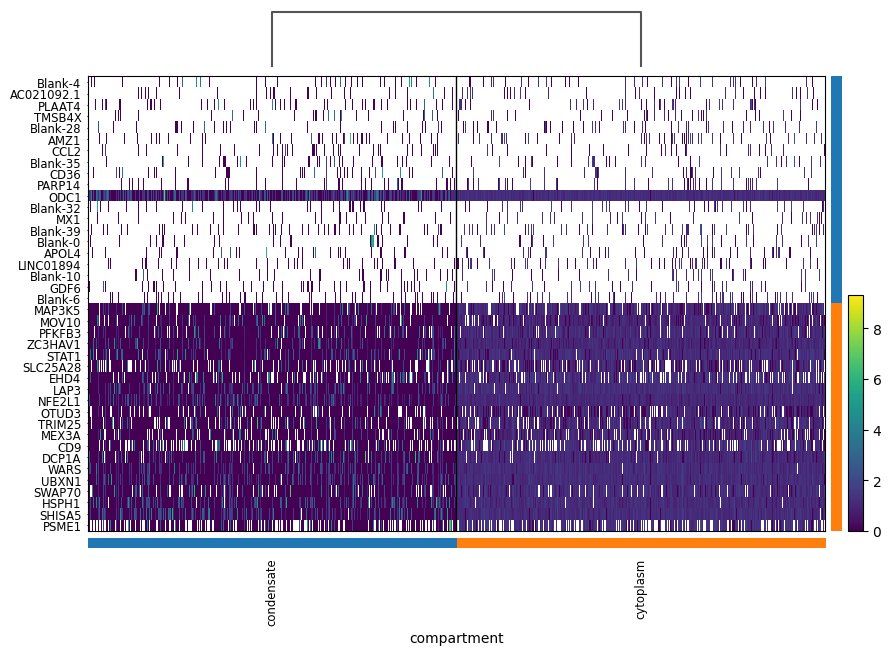

In [147]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=20,
    layer="density",
    swap_axes=True,
    figsize=(10, 7),
    show=False,
);

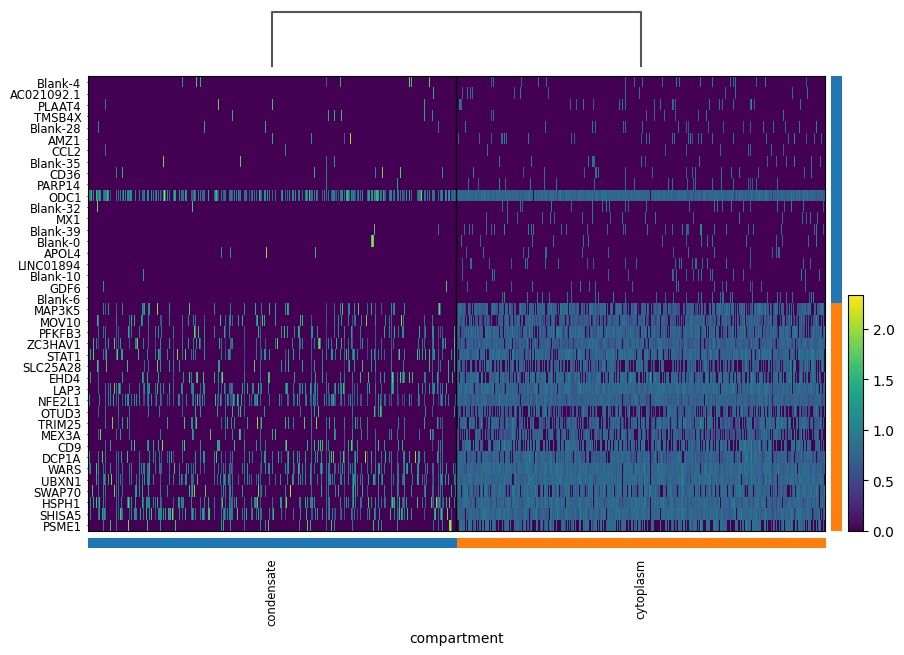

In [148]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=20,
    swap_axes=True,
    figsize=(10, 7),
    show=False,
);

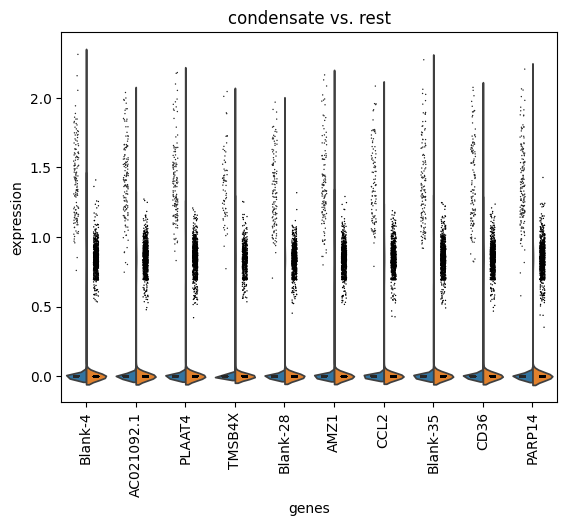

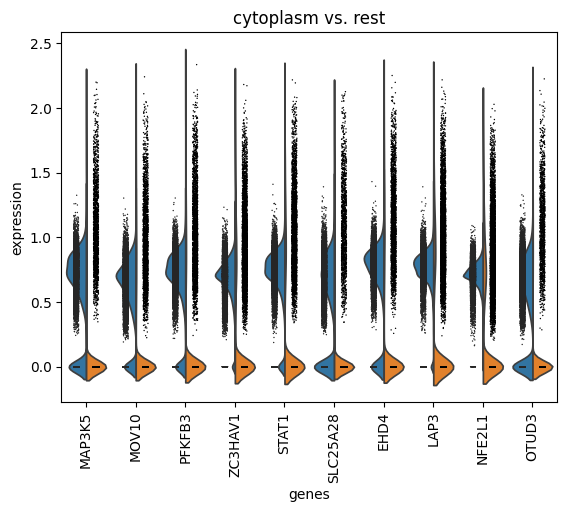

In [149]:
sc.pl.rank_genes_groups_violin(adata, n_genes=10);